Some code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. and from the report and code of Jonas Perolini.

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)


# Imports & Setting up directories

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:  
    PATH = './' # './drive/MyDrive/1_SP_Ham_func/'
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/1_SP_Ham_func/furuta_pendulum/
    %pip install torchdiffeq
    from src.data import *
    from src.dynamics import *
    from src.models import *
    from src.train import *
    from src.plots import *
    from src.trajectories import *
    from src.utils import *
else:
    import sys; sys.path.insert(0, '..') 
    import os
    PATH = '../'
    from src.data import *
    from src.dynamics import *
    from src.models import *
    from src.train import *
    from src.plots import *
    from src.trajectories import *
    from src.utils import *

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torch.optim.lr_scheduler import LinearLR

from torchdiffeq import odeint_adjoint as odeint_adjoint 
# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time
import json
import os
# setting seeds
import random

In [3]:
%load_ext autoreload
%autoreload 2

# Training

#### NESHDNN + mlp + input

##### with constant G

###### chirp, std rescaling ( and loss ) no clipping

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = 'real'  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(
    which=furuta_type)
utype = 'chirp'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 125  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = False  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# Parameters for the training procedure
resnet_config = None
alternating = False  # for Input_HNN, if G is a neural network, train
horizon_type = 'auto'  # 'auto' or 'constant'
horizon = False  # if horizon_type == 'constant', use this horizon
loss_type = 'L2'  # 'L2' or 'L2weighted'
collect_grads = False  # collect gradients in all layers at every epoch
# rescale the difference between nominal and train by the min max of train trajectory in loss function
rescale_loss = True
grad_clip = False  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)  # total number of training epochs


In [ ]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

In [ ]:
# initialise the model that will be trianed
model_name = 'NESHDNN_resnet_conf1'

model_name = 'Input_HNN'

H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4,
            output_dim=1, activation='x+sin(x)^2')
model = Input_HNN(u_func=u_func, G_net=g_func,
                 H_net=H_net, device=device, dissip=False)
model.to(device)
num_params = count_parameters(model)

# create file name from parameters
num_params = count_parameters(model)

save_prefix = name_from_params(Ts, rescale_loss, weights, epoch_number, num_params, utype, model_name,
                               num_trajectories, furuta_type, noise_std,
                               grad_clip, lr_schedule, C_q1, C_q2, horizon, min_max_rescale,w_rescale)
                               
# print some information on the training and file name
print('Total number of epochs:', epoch_number)
print('H_net number of parameters :', num_params)
print('Save file prefix : ', save_prefix)

# Sanity check
is_same_size(horizon_list, switch_steps)

In [ ]:
stats = train(device=device, model=model,
              Ts=Ts,
              train_loader=train_loader,
              test_loader=test_loader,
              w=torch.tensor(weights, device=device),
              grad_clip=grad_clip,
              lr_schedule=lr_schedule,
              begin_decay=begin_decay,
              resnet_config=resnet_config,
              epoch_number=epoch_number,
              alternating=alternating,
              horizon=horizon,
              horizon_type=horizon_type,
              horizon_list=horizon_list,
              switch_steps=switch_steps,
              epochs=epoch_number,
              loss_type=loss_type,
              collect_grads=collect_grads,
              rescale_loss=rescale_loss,
              rescale_dims=rescale_dims
              )


In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
# set all paths and create folders : 
model_path = PATH+'data/'+save_prefix+'/'
stats_path = PATH+'data/'+save_prefix+'/'
plot_path = PATH+'data/'+save_prefix+'/img/'
train_loader_path = PATH + 'data/'+save_prefix+'/datasets/' 
test_loader_path = PATH + 'data/'+save_prefix+'/datasets/' 
os.makedirs(model_path, exist_ok=True)
os.makedirs(stats_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(train_loader_path, exist_ok=True)
os.makedirs(test_loader_path, exist_ok=True)

In [ ]:
torch.save(train_loader, train_loader_path + 'train_loader.pt')
if test_loader is not None:
    torch.save(test_loader, test_loader_path + 'test_loader.pt')

# save model to disk
torch.save(model.state_dict(), model_path+'model')

# save the stats
save_stats(stats, stats_path+'stats.txt')

In [ ]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)
# # loads the stats 
# stats = read_dict(PATH, stats_path)
# # load the model from disk
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()

In [ ]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(len(loss_train))
train_test_loss_plot(loss_train, loss_test, epochs, file_path=plot_path+'/LOSS_train_test.png',
                     title='train and test loss per epoch', horizons=False, switch_steps=switch_steps)

train_test_loss_plot(loss_train, loss_test, epochs, file_path=plot_path+'/LOSS_train_test_warrows.png',
                     title='train and test loss per epoch', horizons=horizon_list[:-1], switch_steps=switch_steps)


In [ ]:
# show train and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader,
                        t_max=horizon_list[-1], n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, show_pred=True, H_or_Input='input',
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
# show only training portion
for n in [0, 50, 70]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, t_max=horizon_list[-1],
                        n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp, t_plot=horizon_list[-1], show_pred=False,
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
# show test and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=test_loader,
                        t_max=horizon_list[-1], n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, show_pred=True, H_or_Input='input',
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype) # instantiate the input function u(t)
gtype = None # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.0 # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1, 1, 1] # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 0]

# generate train and test dataloader objects containing the trajectories
train_loader_2, test_loader_2 = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

In [ ]:
# show test and prediction
title='test set trajectories | no input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_2,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'noinput.png', w_rescale=w_rescale)


In [ ]:
utype = 'sine'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 1  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
# [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
w_rescale = [1, 1, 1, 1]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# generate train and test dataloader objects containing the trajectories
train_loader_3, test_loader_3 = load_data_device(device, init_method, w_rescale,
                                                 u_func, g_func, time_steps,
                                                 shuffle=shuffle,
                                                 num_trajectories=num_trajectories,
                                                 coord_type=coord_type,
                                                 proportion=proportion, batch_size=batch_size,
                                                 Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                                 g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                                 min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)


In [ ]:
# show test and prediction
title='test set trajectories | 1hz sine input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_3,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'1hzsine.png', w_rescale=w_rescale)


In [ ]:
utype = 'sine'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype) # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple' # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.0  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1, 1, 1] # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# generate train and test dataloader objects containing the trajectories
train_loader_4, test_loader_4 = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)
# show test and prediction
title='test set trajectories | 2hz sine input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_4,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_test_set'+str(n)+'2hzsine.png', w_rescale=w_rescale)


###### chirp, all rescaling with clipping

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = 'real'  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(
    which=furuta_type)
utype = 'chirp'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 125  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# Parameters for the training procedure
resnet_config = None
alternating = False  # for Input_HNN, if G is a neural network, train
horizon_type = 'auto'  # 'auto' or 'constant'
horizon = False  # if horizon_type == 'constant', use this horizon
loss_type = 'L2'  # 'L2' or 'L2weighted'
collect_grads = False  # collect gradients in all layers at every epoch
# rescale the difference between nominal and train by the min max of train trajectory in loss function
rescale_loss = True
grad_clip = True  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)  # total number of training epochs


In [ ]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

In [ ]:
# initialise the model that will be trianed
model_name = 'NESHDNN_resnet_conf1'

model_name = 'Input_HNN'

H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4,
            output_dim=1, activation='x+sin(x)^2')
model = Input_HNN(u_func=u_func, G_net=g_func,
                 H_net=H_net, device=device, dissip=False)
model.to(device)
num_params = count_parameters(model)

# create file name from parameters
num_params = count_parameters(model)

save_prefix = name_from_params(Ts, rescale_loss, weights, epoch_number, num_params, utype, model_name,
                               num_trajectories, furuta_type, noise_std,
                               grad_clip, lr_schedule, C_q1, C_q2, horizon, min_max_rescale,w_rescale)
                               
# print some information on the training and file name
print('Total number of epochs:', epoch_number)
print('H_net number of parameters :', num_params)
print('Save file prefix : ', save_prefix)

# Sanity check
is_same_size(horizon_list, switch_steps)

In [ ]:
stats = train(device=device, model=model,
              Ts=Ts,
              train_loader=train_loader,
              test_loader=test_loader,
              w=torch.tensor(weights, device=device),
              grad_clip=grad_clip,
              lr_schedule=lr_schedule,
              begin_decay=begin_decay,
              resnet_config=resnet_config,
              epoch_number=epoch_number,
              alternating=alternating,
              horizon=horizon,
              horizon_type=horizon_type,
              horizon_list=horizon_list,
              switch_steps=switch_steps,
              epochs=epoch_number,
              loss_type=loss_type,
              collect_grads=collect_grads,
              rescale_loss=rescale_loss,
              rescale_dims=rescale_dims
              )


In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
# set all paths and create folders : 
model_path = PATH+'data/'+save_prefix+'/'
stats_path = PATH+'data/'+save_prefix+'/'
plot_path = PATH+'data/'+save_prefix+'/img/'
train_loader_path = PATH + 'data/'+save_prefix+'/datasets/' 
test_loader_path = PATH + 'data/'+save_prefix+'/datasets/' 
os.makedirs(model_path, exist_ok=True)
os.makedirs(stats_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(train_loader_path, exist_ok=True)
os.makedirs(test_loader_path, exist_ok=True)

In [ ]:
torch.save(train_loader, train_loader_path + 'train_loader.pt')
if test_loader is not None:
    torch.save(test_loader, test_loader_path + 'test_loader.pt')

# save model to disk
torch.save(model.state_dict(), model_path+'model')

# save the stats
save_stats(stats, stats_path+'stats.txt')

In [ ]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)
# # loads the stats 
# stats = read_dict(PATH, stats_path)
# # load the model from disk
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()

In [ ]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(len(loss_train))
train_test_loss_plot(loss_train, loss_test, epochs, file_path=plot_path+'/LOSS_train_test.png',
                     title='train and test loss per epoch', horizons=False, switch_steps=switch_steps)

train_test_loss_plot(loss_train, loss_test, epochs, file_path=plot_path+'/LOSS_train_test_warrows.png',
                     title='train and test loss per epoch', horizons=horizon_list[:-1], switch_steps=switch_steps)


In [ ]:
# show train and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader,
                        t_max=horizon_list[-1], n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, show_pred=True, H_or_Input='input',
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
# show only training portion
for n in [0, 50, 70]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, t_max=horizon_list[-1],
                        n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp, t_plot=horizon_list[-1], show_pred=False,
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
# show test and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=test_loader,
                        t_max=horizon_list[-1], n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, show_pred=True, H_or_Input='input',
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype) # instantiate the input function u(t)
gtype = None # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.0 # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1, 1, 1] # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 0]

# generate train and test dataloader objects containing the trajectories
train_loader_2, test_loader_2 = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

In [ ]:
# show test and prediction
title='test set trajectories | no input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_2,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'noinput.png', w_rescale=w_rescale)


In [ ]:
utype = 'sine'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 1  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
# [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
w_rescale = [1, 1, 1, 1]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# generate train and test dataloader objects containing the trajectories
train_loader_3, test_loader_3 = load_data_device(device, init_method, w_rescale,
                                                 u_func, g_func, time_steps,
                                                 shuffle=shuffle,
                                                 num_trajectories=num_trajectories,
                                                 coord_type=coord_type,
                                                 proportion=proportion, batch_size=batch_size,
                                                 Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                                 g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                                 min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)


In [ ]:
# show test and prediction
title='test set trajectories | 1hz sine input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_3,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'1hzsine.png', w_rescale=w_rescale)


In [ ]:
utype = 'sine'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype) # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple' # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.0  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1, 1, 1] # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# generate train and test dataloader objects containing the trajectories
train_loader_4, test_loader_4 = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)
# show test and prediction
title='test set trajectories | 2hz sine input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_4,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_test_set'+str(n)+'2hzsine.png', w_rescale=w_rescale)

##### with NN for G

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = 'real'  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(
    which=furuta_type)
utype = 'chirp'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 125  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# Parameters for the training procedure
resnet_config = None
alternating = False  # for Input_HNN, if G is a neural network, train
horizon_type = 'auto'  # 'auto' or 'constant'
horizon = False  # if horizon_type == 'constant', use this horizon
loss_type = 'L2'  # 'L2' or 'L2weighted'
collect_grads = False  # collect gradients in all layers at every epoch
# rescale the difference between nominal and train by the min max of train trajectory in loss function
rescale_loss = True
grad_clip = True  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)  # total number of training epochs


In [ ]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

In [ ]:
# initialise the model that will be trianed

model_name = 'Input_HNN_GNN'

H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4,
            output_dim=1, activation='x+sin(x)^2')
G_net = MLP(input_dim=4, hidden_dim=60, nb_hidden_layers=1,
            output_dim=4, activation='x+sin(x)^2')
model = Input_HNN(u_func=u_func, G_net=G_net,
                 H_net=H_net, device=device, dissip=False)
model.to(device)
num_params = count_parameters(H_net)
num_params_g = count_parameters(G_net)
# create file name from parameters


save_prefix = name_from_params(Ts, rescale_loss, weights, epoch_number, num_params, utype, model_name,
                               num_trajectories, furuta_type, noise_std,
                               grad_clip, lr_schedule, C_q1, C_q2, horizon, min_max_rescale,w_rescale)
                               
# print some information on the training and file name
print('Total number of epochs:', epoch_number)
print('H_net number of parameters :', num_params)
print('G_net number of parameters :', num_params_g)
print('Save file prefix : ', save_prefix)

# Sanity check
is_same_size(horizon_list, switch_steps)

In [ ]:
stats = train(device=device, model=model,
              Ts=Ts,
              train_loader=train_loader,
              test_loader=test_loader,
              w=torch.tensor(weights, device=device),
              grad_clip=grad_clip,
              lr_schedule=lr_schedule,
              begin_decay=begin_decay,
              resnet_config=resnet_config,
              epoch_number=epoch_number,
              alternating=alternating,
              horizon=horizon,
              horizon_type=horizon_type,
              horizon_list=horizon_list,
              switch_steps=switch_steps,
              epochs=epoch_number,
              loss_type=loss_type,
              collect_grads=collect_grads,
              rescale_loss=rescale_loss,
              rescale_dims=rescale_dims
              )


In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
# set all paths and create folders : 
model_path = PATH+'data/'+save_prefix+'/'
stats_path = PATH+'data/'+save_prefix+'/'
plot_path = PATH+'data/'+save_prefix+'/img/'
train_loader_path = PATH + 'data/'+save_prefix+'/datasets/' 
test_loader_path = PATH + 'data/'+save_prefix+'/datasets/' 
os.makedirs(model_path, exist_ok=True)
os.makedirs(stats_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(train_loader_path, exist_ok=True)
os.makedirs(test_loader_path, exist_ok=True)

In [ ]:
torch.save(train_loader, train_loader_path + 'train_loader.pt')
if test_loader is not None:
    torch.save(test_loader, test_loader_path + 'test_loader.pt')

# save model to disk
torch.save(model.state_dict(), model_path+'model')

# save the stats
save_stats(stats, stats_path+'stats.txt')

In [ ]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)
# # loads the stats 
# stats = read_dict(PATH, stats_path)
# # load the model from disk
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()

In [ ]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(len(loss_train))
train_test_loss_plot(loss_train, loss_test, epochs, file_path=plot_path+'/LOSS_train_test.png',
                     title='train and test loss per epoch', horizons=False, switch_steps=switch_steps)

train_test_loss_plot(loss_train, loss_test, epochs, file_path=plot_path+'/LOSS_train_test_warrows.png',
                     title='train and test loss per epoch', horizons=horizon_list[:-1], switch_steps=switch_steps)


In [ ]:
# show train and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader,
                        t_max=horizon_list[-1], n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, show_pred=True, H_or_Input='input',
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
# show only training portion
for n in [0, 50, 70]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, t_max=horizon_list[-1],
                        n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp, t_plot=horizon_list[-1], show_pred=False,
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
# show test and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=test_loader,
                        t_max=horizon_list[-1], n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, show_pred=True, H_or_Input='input',
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype) # instantiate the input function u(t)
gtype = None # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.0 # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1, 1, 1] # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 0]

# generate train and test dataloader objects containing the trajectories
train_loader_2, test_loader_2 = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

In [ ]:
# show test and prediction
title='test set trajectories | no input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_2,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'noinput.png', w_rescale=w_rescale)


In [ ]:
utype = 'sine'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 1  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
# [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
w_rescale = [1, 1, 1, 1]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# generate train and test dataloader objects containing the trajectories
train_loader_3, test_loader_3 = load_data_device(device, init_method, w_rescale,
                                                 u_func, g_func, time_steps,
                                                 shuffle=shuffle,
                                                 num_trajectories=num_trajectories,
                                                 coord_type=coord_type,
                                                 proportion=proportion, batch_size=batch_size,
                                                 Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                                 g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                                 min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)


In [ ]:
# show test and prediction
title='test set trajectories | 1hz sine input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_3,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'1hzsine.png', w_rescale=w_rescale)


In [ ]:
utype = 'sine'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype) # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple' # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.0  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1, 1, 1] # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# generate train and test dataloader objects containing the trajectories
train_loader_4, test_loader_4 = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)
# show test and prediction
title='test set trajectories | 2hz sine input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_4,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_test_set'+str(n)+'2hzsine.png', w_rescale=w_rescale)

#### Expanding_HNN

In [4]:
set_all_seeds(manualSeed=123, new_results=False)
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = 'real'  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(
    which=furuta_type)
utype = 'chirp'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 125  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# Parameters for the training procedure
resnet_config = 1
alternating = False  # for Input_HNN, if G is a neural network, train
horizon_type = 'auto'  # 'auto' or 'constant'
horizon = False  # if horizon_type == 'constant', use this horizon
loss_type = 'L2'  # 'L2' or 'L2weighted'
collect_grads = False  # collect gradients in all layers at every epoch
# rescale the difference between nominal and train by the min max of train trajectory in loss function
rescale_loss = True
grad_clip = True  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)  # total number of training epochs


Random Seed:  123
cpu


In [5]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

In [6]:
# initialise the model that will be trianed


model_name = 'Expanding_HNN'

H_net = Expanding_ResNet(resblock_list=[0], num_blocks = 6, input_dim=4, hidden_dim=45, 
                nb_hidden_layers=2, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2')
num_params = 0
for block in H_net.resblocks:
    block.to(device)
    num_params += count_parameters(block)

model = Input_HNN(u_func=u_func, G_net=g_func,
                 H_net=H_net, device=device, dissip=False)
                 
model.to(device)
num_params1 = count_parameters(model)
num_params2 = count_parameters(model.H_net.resblocks[0])
num_params += num_params1
# create file name from parameters


save_prefix = name_from_params(Ts, rescale_loss, weights, epoch_number, num_params, utype, model_name,
                               num_trajectories, furuta_type, noise_std,
                               grad_clip, lr_schedule, C_q1, C_q2, horizon, min_max_rescale,w_rescale)
                               
# print some information on the training and file name

print('Total number of epochs:', epoch_number)
print('mlp number of parameters :', num_params1)
print('resblock number of parameters :', num_params2)
print('Total number of H_net parameters :', num_params)
print('Save file prefix : ', save_prefix)
# Sanity check
is_same_size(horizon_list, switch_steps)

Total number of epochs: 700
mlp number of parameters : 4413
resblock number of parameters : 4276
Total number of H_net parameters : 30069
Save file prefix :  Expanding_HNN_chirp_125traj_real_noise0.0_700e_p30k_Ts0.005_gradcl_nodissip_rescaledloss_trajminmaxrescale_stdrescale_
horizon_list and switch_steps have the same size


horizon length : 50
Model size increased
min max values updated


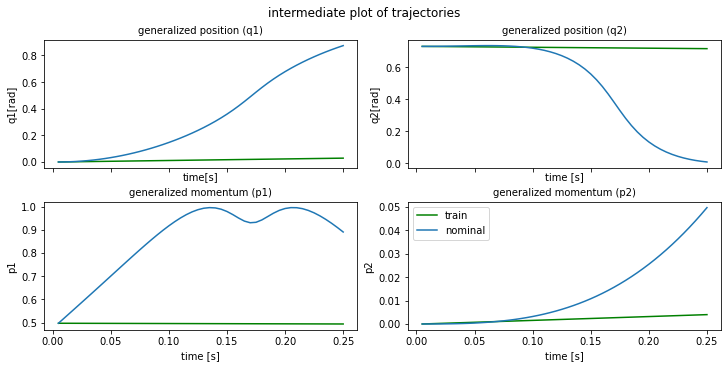

plot time : 0.6116483211517334
min max values updated
epoch    0 | train time 1.92 | train loss 1.123311e+00 | test loss 1.066055e+00 | test time 0.36  
epoch    1 | train time 1.25 | train loss 1.072679e+00 
epoch    2 | train time 1.26 | train loss 1.046020e+00 
epoch    3 | train time 1.28 | train loss 1.040599e+00 
epoch    4 | train time 1.15 | train loss 1.039495e+00 
epoch    5 | train time 1.23 | train loss 1.031155e+00 
epoch    6 | train time 1.19 | train loss 1.017753e+00 
epoch    7 | train time 1.26 | train loss 1.004050e+00 
epoch    8 | train time 1.30 | train loss 9.927318e-01 
epoch    9 | train time 1.31 | train loss 9.838794e-01 


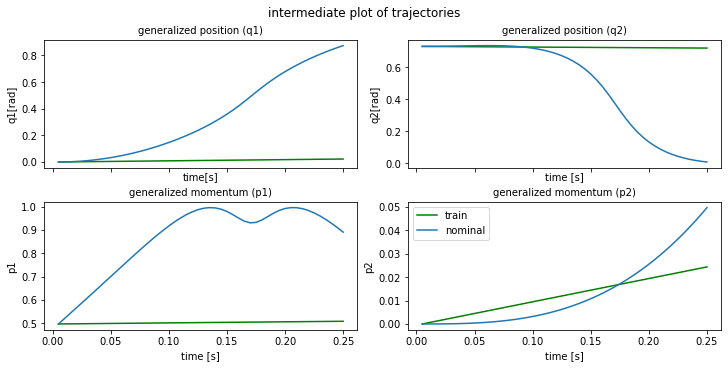

plot time : 0.6846239566802979
epoch   10 | train time 2.00 | train loss 9.759001e-01 | test loss 9.618356e-01 | test time 0.37  
epoch   11 | train time 1.35 | train loss 9.669299e-01 
epoch   12 | train time 1.16 | train loss 9.558859e-01 
epoch   13 | train time 1.26 | train loss 9.427770e-01 
epoch   14 | train time 1.23 | train loss 9.284187e-01 
epoch   15 | train time 1.29 | train loss 9.138407e-01 
epoch   16 | train time 1.16 | train loss 8.995845e-01 
epoch   17 | train time 1.27 | train loss 8.852119e-01 
epoch   18 | train time 1.48 | train loss 8.696101e-01 


KeyboardInterrupt: 

In [7]:
stats = train(device=device, model=model,
              Ts=Ts,
              train_loader=train_loader,
              test_loader=test_loader,
              w=torch.tensor(weights, device=device),
              grad_clip=grad_clip,
              lr_schedule=lr_schedule,
              begin_decay=begin_decay,
              resnet_config=resnet_config,
              epoch_number=epoch_number,
              alternating=alternating,
              horizon=horizon,
              horizon_type=horizon_type,
              horizon_list=horizon_list,
              switch_steps=switch_steps,
              epochs=epoch_number,
              loss_type=loss_type,
              collect_grads=collect_grads,
              rescale_loss=rescale_loss,
              rescale_dims=rescale_dims
              )


In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
# set all paths and create folders : 
model_path = PATH+'data/'+save_prefix+'/'
stats_path = PATH+'data/'+save_prefix+'/'
plot_path = PATH+'data/'+save_prefix+'/img/'
train_loader_path = PATH + 'data/'+save_prefix+'/datasets/' 
test_loader_path = PATH + 'data/'+save_prefix+'/datasets/' 
os.makedirs(model_path, exist_ok=True)
os.makedirs(stats_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(train_loader_path, exist_ok=True)
os.makedirs(test_loader_path, exist_ok=True)

In [ ]:
torch.save(train_loader, train_loader_path + 'train_loader.pt')
if test_loader is not None:
    torch.save(test_loader, test_loader_path + 'test_loader.pt')

# save model to disk
torch.save(model.state_dict(), model_path+'model')

# save the stats
save_stats(stats, stats_path+'stats.txt')

In [ ]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)
# # loads the stats 
# stats = read_dict(PATH, stats_path)
# # load the model from disk
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()

In [ ]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(len(loss_train))
train_test_loss_plot(loss_train, loss_test, epochs, file_path=plot_path+'/LOSS_train_test.png',
                     title='train and test loss per epoch', horizons=False, switch_steps=switch_steps)

train_test_loss_plot(loss_train, loss_test, epochs, file_path=plot_path+'/LOSS_train_test_warrows.png',
                     title='train and test loss per epoch', horizons=horizon_list[:-1], switch_steps=switch_steps)


In [ ]:
# show train and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader,
                        t_max=horizon_list[-1], n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, show_pred=True, H_or_Input='input',
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
# show only training portion
for n in [0, 50, 70]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, t_max=horizon_list[-1],
                        n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp, t_plot=horizon_list[-1], show_pred=False,
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
# show test and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=test_loader,
                        t_max=horizon_list[-1], n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, show_pred=True, H_or_Input='input',
                        title='Test set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype) # instantiate the input function u(t)
gtype = None # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.0 # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1, 1, 1] # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 0]

# generate train and test dataloader objects containing the trajectories
train_loader_2, test_loader_2 = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

In [ ]:
# show test and prediction
title='test set trajectories | no input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_2,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'noinput.png', w_rescale=w_rescale)


In [ ]:
utype = 'sine'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 1  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
# [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
w_rescale = [1, 1, 1, 1]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# generate train and test dataloader objects containing the trajectories
train_loader_3, test_loader_3 = load_data_device(device, init_method, w_rescale,
                                                 u_func, g_func, time_steps,
                                                 shuffle=shuffle,
                                                 num_trajectories=num_trajectories,
                                                 coord_type=coord_type,
                                                 proportion=proportion, batch_size=batch_size,
                                                 Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                                 g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                                 min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)


In [ ]:
# show test and prediction
title='test set trajectories | 1hz sine input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_3,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'1hzsine.png', w_rescale=w_rescale)


In [ ]:
utype = 'sine'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype) # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple' # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.0  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1, 1, 1] # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# generate train and test dataloader objects containing the trajectories
train_loader_4, test_loader_4 = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)
# show test and prediction
title='test set trajectories | 2hz sine input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_4,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_test_set'+str(n)+'2hzsine.png', w_rescale=w_rescale)


#### Expanding_HNN_wide

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = 'real'  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(
    which=furuta_type)
utype = 'chirp'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 125  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# Parameters for the training procedure
resnet_config = 1
alternating = False  # for Input_HNN, if G is a neural network, train
horizon_type = 'auto'  # 'auto' or 'constant'
horizon = False  # if horizon_type == 'constant', use this horizon
loss_type = 'L2'  # 'L2' or 'L2weighted'
collect_grads = False  # collect gradients in all layers at every epoch
# rescale the difference between nominal and train by the min max of train trajectory in loss function
rescale_loss = True
grad_clip = True  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)  # total number of training epochs


In [ ]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

In [24]:
# initialise the model that will be trianed


model_name = 'Expanding_HNN_wide_'

H_net = Expanding_ResNet_wide(resblock_list=[0], num_blocks = 6, input_dim=4, hidden_dim=45, 
                nb_hidden_layers=2, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2')
num_params = 0
for block in H_net.resblocks:
    block.to(device)
    num_params += count_parameters(block)

model = Input_HNN(u_func=u_func, G_net=g_func,
                 H_net=H_net, device=device, dissip=False)
                 
model.to(device)
num_params1 = count_parameters(model)
num_params2 = count_parameters(model.H_net.resblocks[0])
num_params += num_params1
# create file name from parameters


save_prefix = name_from_params(Ts, rescale_loss, weights, epoch_number, num_params, utype, model_name,
                               num_trajectories, furuta_type, noise_std,
                               grad_clip, lr_schedule, C_q1, C_q2, horizon, min_max_rescale,w_rescale)
                               
# print some information on the training and file name

print('Total number of epochs:', epoch_number)
print('mlp number of parameters :', num_params1)
print('resblock number of parameters :', num_params2)
print('Total number of H_net parameters :', num_params)
print('Save file prefix : ', save_prefix)
# Sanity check
is_same_size(horizon_list, switch_steps)

Total number of epochs: 700
mlp number of parameters : 4413
resblock number of parameters : 4549
Total number of H_net parameters : 31707
Save file prefix :  Expanding_HNN_chirp_125traj_real_noise0.0_700e_p31k_Ts0.005_gradcl_nodissip_rescaledloss_trajminmaxrescale_stdrescale_
horizon_list and switch_steps have the same size


In [ ]:
stats = train(device=device, model=model,
              Ts=Ts,
              train_loader=train_loader,
              test_loader=test_loader,
              w=torch.tensor(weights, device=device),
              grad_clip=grad_clip,
              lr_schedule=lr_schedule,
              begin_decay=begin_decay,
              resnet_config=resnet_config,
              epoch_number=epoch_number,
              alternating=alternating,
              horizon=horizon,
              horizon_type=horizon_type,
              horizon_list=horizon_list,
              switch_steps=switch_steps,
              epochs=epoch_number,
              loss_type=loss_type,
              collect_grads=collect_grads,
              rescale_loss=rescale_loss,
              rescale_dims=rescale_dims
              )


In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
# set all paths and create folders : 
model_path = PATH+'data/'+save_prefix+'/'
stats_path = PATH+'data/'+save_prefix+'/'
plot_path = PATH+'data/'+save_prefix+'/img/'
train_loader_path = PATH + 'data/'+save_prefix+'/datasets/' 
test_loader_path = PATH + 'data/'+save_prefix+'/datasets/' 
os.makedirs(model_path, exist_ok=True)
os.makedirs(stats_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(train_loader_path, exist_ok=True)
os.makedirs(test_loader_path, exist_ok=True)

In [ ]:
torch.save(train_loader, train_loader_path + 'train_loader.pt')
if test_loader is not None:
    torch.save(test_loader, test_loader_path + 'test_loader.pt')

# save model to disk
torch.save(model.state_dict(), model_path+'model')

# save the stats
save_stats(stats, stats_path+'stats.txt')

In [ ]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)
# # loads the stats 
# stats = read_dict(PATH, stats_path)
# # load the model from disk
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()

In [ ]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(len(loss_train))
train_test_loss_plot(loss_train, loss_test, epochs, file_path=plot_path+'/LOSS_train_test.png',
                     title='train and test loss per epoch', horizons=False, switch_steps=switch_steps)

train_test_loss_plot(loss_train, loss_test, epochs, file_path=plot_path+'/LOSS_train_test_warrows.png',
                     title='train and test loss per epoch', horizons=horizon_list[:-1], switch_steps=switch_steps)


In [ ]:
# show train and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader,
                        t_max=horizon_list[-1], n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, show_pred=True, H_or_Input='input',
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
# show only training portion
for n in [0, 50, 70]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, t_max=horizon_list[-1],
                        n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp, t_plot=horizon_list[-1], show_pred=False,
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
# show test and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=test_loader,
                        t_max=horizon_list[-1], n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, show_pred=True, H_or_Input='input',
                        title='Test set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype) # instantiate the input function u(t)
gtype = None # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.0 # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1, 1, 1] # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 0]

# generate train and test dataloader objects containing the trajectories
train_loader_2, test_loader_2 = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

In [ ]:
# show test and prediction
title='test set trajectories | no input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_2,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'noinput.png', w_rescale=w_rescale)


In [ ]:
utype = 'sine'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 1  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
# [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
w_rescale = [1, 1, 1, 1]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# generate train and test dataloader objects containing the trajectories
train_loader_3, test_loader_3 = load_data_device(device, init_method, w_rescale,
                                                 u_func, g_func, time_steps,
                                                 shuffle=shuffle,
                                                 num_trajectories=num_trajectories,
                                                 coord_type=coord_type,
                                                 proportion=proportion, batch_size=batch_size,
                                                 Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                                 g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                                 min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)


In [ ]:
# show test and prediction
title='test set trajectories | 1hz sine input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_3,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'1hzsine.png', w_rescale=w_rescale)


In [ ]:
utype = 'sine'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype) # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple' # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.0  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1, 1, 1] # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# generate train and test dataloader objects containing the trajectories
train_loader_4, test_loader_4 = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)
# show test and prediction
title='test set trajectories | 2hz sine input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_4,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_test_set'+str(n)+'2hzsine.png', w_rescale=w_rescale)


#### Interp_HNN

In [33]:
set_all_seeds(manualSeed=123, new_results=False)
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = 'real'  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(
    which=furuta_type)
utype = 'chirp'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 125  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# Parameters for the training procedure
resnet_config = 1
alternating = False  # for Input_HNN, if G is a neural network, train
horizon_type = 'auto'  # 'auto' or 'constant'
horizon = False  # if horizon_type == 'constant', use this horizon
loss_type = 'L2'  # 'L2' or 'L2weighted'
collect_grads = False  # collect gradients in all layers at every epoch
# rescale the difference between nominal and train by the min max of train trajectory in loss function
rescale_loss = True
grad_clip = True  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)  # total number of training epochs

Random Seed:  123
cpu


In [34]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

In [35]:
# initialise the model that will be trianed

model_name = 'Interp_HNN'

H_net = Interp_ResNet(resblock_list=[0,16], num_blocks = 17, input_dim=4, hidden_dim=25, 
                nb_hidden_layers=2, output_dim=1, activation_res='x+sin(x)^2', activation_mlp='x+sin(x)^2')
num_params = 0
for block in H_net.resblocks:
    block.to(device)
    num_params += count_parameters(block)

model = Input_HNN(u_func=u_func, G_net=g_func,
                 H_net=H_net, device=device, dissip=False)
                 
model.to(device)
num_params1 = count_parameters(model)
num_params2 = count_parameters(model.H_net.resblocks[0])
num_params += num_params1
# create file name from parameters

save_prefix = name_from_params(Ts, rescale_loss, weights, epoch_number, num_params, utype, model_name,
                               num_trajectories, furuta_type, noise_std,
                               grad_clip, lr_schedule, C_q1, C_q2, horizon, min_max_rescale,w_rescale)

# print some information on the training and file name

print('Total number of epochs:', epoch_number)
print('mlp number of parameters :', num_params1)
print('resblock number of parameters :', num_params2)
print('Total number of H_net parameters :', num_params)
print('Save file prefix : ', save_prefix)

# Sanity check
is_same_size(horizon_list, switch_steps)

Total number of epochs: 6
mlp number of parameters : 1453
resblock number of parameters : 1529
Total number of H_net parameters : 27446
Save file prefix :  Interp_HNN_chirp_125traj_real_noise0.0_6e_p27k_Ts0.005_gradcl_nodissip_rescaledloss_trajminmaxrescale_stdrescale_
horizon_list and switch_steps have the same size


horizon length : 50
Model size increased
min max values updated


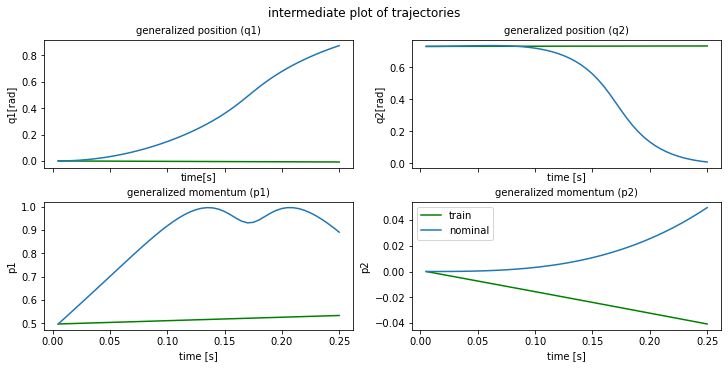

plot time : 0.618645429611206
min max values updated
epoch    0 | train time 1.45 | train loss 1.674724e+00 | test loss 1.552937e+00 | test time 0.33  
horizon length : 100
Model size increased
min max values updated
epoch    1 | train time 2.35 | train loss 1.309743e+00 
horizon length : 150
Model size increased
min max values updated
epoch    2 | train time 4.76 | train loss 1.081162e+00 
horizon length : 200
Model size increased
min max values updated
epoch    3 | train time 8.12 | train loss 1.208801e+00 
horizon length : 250
Model size increased
min max values updated
epoch    4 | train time 12.49 | train loss 1.215763e+00 
horizon length : 300
Model size increased
min max values updated
epoch    5 | train time 18.48 | train loss 1.224987e+00 


In [36]:
stats = train(device=device, model=model,
              Ts=Ts,
              train_loader=train_loader,
              test_loader=test_loader,
              w=torch.tensor(weights, device=device),
              grad_clip=grad_clip,
              lr_schedule=lr_schedule,
              begin_decay=begin_decay,
              resnet_config=resnet_config,
              epoch_number=epoch_number,
              alternating=alternating,
              horizon=horizon,
              horizon_type=horizon_type,
              horizon_list=horizon_list,
              switch_steps=switch_steps,
              epochs=epoch_number,
              loss_type=loss_type,
              collect_grads=collect_grads,
              rescale_loss=rescale_loss,
              rescale_dims=rescale_dims
              )


In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
# set all paths and create folders : 
model_path = PATH+'data/'+save_prefix+'/'
stats_path = PATH+'data/'+save_prefix+'/'
plot_path = PATH+'data/'+save_prefix+'/img/'
train_loader_path = PATH + 'data/'+save_prefix+'/datasets/' 
test_loader_path = PATH + 'data/'+save_prefix+'/datasets/' 
os.makedirs(model_path, exist_ok=True)
os.makedirs(stats_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(train_loader_path, exist_ok=True)
os.makedirs(test_loader_path, exist_ok=True)

In [ ]:
torch.save(train_loader, train_loader_path + 'train_loader.pt')
if test_loader is not None:
    torch.save(test_loader, test_loader_path + 'test_loader.pt')

# save model to disk
torch.save(model.state_dict(), model_path+'model')

# save the stats
save_stats(stats, stats_path+'stats.txt')

In [ ]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)
# # loads the stats 
# stats = read_dict(PATH, stats_path)
# # load the model from disk
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()

In [ ]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(len(loss_train))
train_test_loss_plot(loss_train, loss_test, epochs, file_path=plot_path+'/LOSS_train_test.png',
                     title='train and test loss per epoch', horizons=False, switch_steps=switch_steps)

train_test_loss_plot(loss_train, loss_test, epochs, file_path=plot_path+'/LOSS_train_test_warrows.png',
                     title='train and test loss per epoch', horizons=horizon_list[:-1], switch_steps=switch_steps)


In [ ]:
# show train and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader,
                        t_max=horizon_list[-1], n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, show_pred=True, H_or_Input='input',
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
# show only training portion
for n in [0, 50, 70]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, t_max=horizon_list[-1],
                        n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp, t_plot=horizon_list[-1], show_pred=False,
                        title='Train set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
# show test and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=test_loader,
                        t_max=horizon_list[-1], n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, show_pred=True, H_or_Input='input',
                        title='Test set trajectories', file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'.png', w_rescale=w_rescale)


In [ ]:
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype) # instantiate the input function u(t)
gtype = None # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.0 # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1, 1, 1] # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 0]

# generate train and test dataloader objects containing the trajectories
train_loader_2, test_loader_2 = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)

In [ ]:
# show test and prediction
title='test set trajectories | no input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_2,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'noinput.png', w_rescale=w_rescale)


In [ ]:
utype = 'sine'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 1  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple'  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
# [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
w_rescale = [1, 1, 1, 1]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# generate train and test dataloader objects containing the trajectories
train_loader_3, test_loader_3 = load_data_device(device, init_method, w_rescale,
                                                 u_func, g_func, time_steps,
                                                 shuffle=shuffle,
                                                 num_trajectories=num_trajectories,
                                                 coord_type=coord_type,
                                                 proportion=proportion, batch_size=batch_size,
                                                 Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                                 g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                                 min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)


In [ ]:
# show test and prediction
title='test set trajectories | 1hz sine input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_3,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_train_set'+str(n)+'1hzsine.png', w_rescale=w_rescale)


In [ ]:
utype = 'sine'  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype) # instantiate the input function u(t)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 2  # 4 # 1.4
u_func.params['scale'] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = 'simple' # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = 'random_nozero'  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 25  # number of trajectories in total
proportion = 0.0  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1, 1, 1] # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = 'hamiltonian'
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# generate train and test dataloader objects containing the trajectories
train_loader_4, test_loader_4 = load_data_device(device, init_method, w_rescale,
                                             u_func, g_func, time_steps,
                                             shuffle=shuffle,
                                             num_trajectories=num_trajectories,
                                             coord_type=coord_type,
                                             proportion=proportion, batch_size=batch_size,
                                             Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2,
                                             g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                                             min_max_rescale=min_max_rescale, rescale_dims=rescale_dims)
# show test and prediction
title='test set trajectories | 2hz sine input'
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader_4,
                        t_max=time_steps, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                        t_plot=time_steps, only_pred=True, show_pred=True, H_or_Input='input',
                        title=title, file_path=plot_path+'/TRAJECTORIES_test_set'+str(n)+'2hzsine.png', w_rescale=w_rescale)
